# Datalogger del Invernaculo

## Resumen: 

En un apartado del trabajo practico N°1 estaba estipulado la medicion de temperatura 
y la medicion de luz , cada vez que se procediera a regar (cada 4 o menos dias).
dicho TP tiene una duracion de 80 dias.

Por lo que reconverti un detector de metales en un dataloger en 3 horas (pasadas las 00:00), 
de las cuales 1 hora fue test's para calibrarlo, quedando solo un termometro funcional (ya que el otro estaba estropeado) y el LDR GL55
 
Ya habia visitado el invernaculo antes, y sabia que estaba un poco abandonado a la maleza.

A medida que iban avanzando los registros, y contrastando con los valores esperados, me ofreci a remover 
la maleza.




## Sensores:

* Termometro:
    * Esta cubierto con un papel de aluminio para que siempre este a la sombra.
    * Ubicado sobre la base de las macetas de las plantas de avena.
* Sensor de luz:  es el sensor LDR GL55 CdS,  como se muestra en el siguiente grafico: 

    * tiene un pico espectral sobre 600nm:
    * ![GraficasLDR](ldr-graficas.png).
    * y posee una variacion en lux:
    * ![Graficas](LDR-datasheet.jpg)









## Consideraciones: 


### Grafico de absorcion de la clorofila:

* ![GraficasLDR](clorofila.jpg).

    * Como puede verse, los picos no coinciden con el LDR, pero puedo inferirlos ya que el sol
      entrega de manera pareja la energia en el espectro visible, como se puede ver en la siguiente
      imagen:
### Espectro Solar:


* ![Espectrosolar](Solar_Spectrum.png)





### La siguiente tabla muestra niveles comunes de iluminación de fuentes de luz natural:

|                                 | Magnitud estelar | Iluminancia: Lux |
|---------------------------------|------------------|------------------|
| Sol en el cenit                 |      -26.7       |     130000       |
| Luz diurna completa (sin sol directo) | -24 a -25     | 10000-25000      |
| Día nublado                     |      -21         |     1000         |
| Día muy nublado                 |      -19         |      100         |
| Crepúsculo                      |      -16         |       10         |
| Crepúsculo profundo             |      -14         |        1         |
| 1 candela a 1 metro de distancia|    -13.9         |      1.00        |
| Luna llena en el cenit          |    -12.5         |     0.267        |

Fuente: [How bright are natural light sources?](https://stjarnhimlen.se/comp/radfaq.html#10)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#Spline / Interpolación suave
from scipy.interpolate import UnivariateSpline

#Scateerplot?
import seaborn as sns

#Tukey y shapiro
import scipy.stats as stats

from datetime import date, timedelta, time

In [2]:
ruta_archivo = "LOGS_eco2_tp1_160525.csv"

In [3]:
cabeceras=["Hora", "Fecha", "Temp1", "Luz"]
data = pd.read_csv(ruta_archivo, sep=',', encoding = 'utf8', names = cabeceras)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87360 entries, 0 to 87359
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hora    87360 non-null  object 
 1   Fecha   87360 non-null  object 
 2   Temp1   87360 non-null  float64
 3   Luz     87360 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 2.7+ MB


In [4]:
#Eliminar las primeras 518 filas correspondientes a las pruebas
#fila 1257 con errores
#data = data.iloc[518:].reset_index(drop=True)

In [5]:
#Reemplazar valores erroneos por castear a shortint por error
data = data.replace(-31470, 34064)

In [6]:
#linea 1256 con error,  165:165:165  | supongo que fue un rayo astronomico
data.loc[1256, 'Hora'] = '10:29:45'
data.loc[1256, 'Fecha'] = '15-03-2025'

In [7]:
data['Timestamp'] = data['Fecha'] +" "+ data['Hora']
data['Timestamp'] = data['Timestamp'].astype(str).str.replace('/', '-')
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M:%S')

In [8]:
#Ya tengo el timestamp, por lo que dropeo columnas
data = data.drop(columns = 'Hora')
data = data.drop(columns = 'Fecha')

In [9]:
# Función para redondear segundos a minutos:
# Asi tengo la mismas marcas de tiempo
def redondear_al_minuto(ts):
    if ts.second < 30:
        return ts.replace(second=0, microsecond=0)
    else:
        return (ts + pd.Timedelta(minutes=1)).replace(second=0, microsecond=0)

# Aplicar redondeo
datos_f = data
datos_f['Timestamp_redondeado'] = datos_f['Timestamp'].apply(redondear_al_minuto)

In [10]:
duplicados = datos_f[datos_f.duplicated('Timestamp_redondeado', keep=False)]
print(duplicados)

       Temp1  Luz           Timestamp Timestamp_redondeado
33161  19.29  700 2025-04-07 13:10:49  2025-04-07 13:11:00
33162  19.20  700 2025-04-07 13:11:09  2025-04-07 13:11:00


In [11]:
#Borrado de duplicados
datos_f = datos_f.drop_duplicates(subset='Timestamp_redondeado', keep='first')
duplicados = datos_f[datos_f.duplicated('Timestamp_redondeado', keep=False)]
print(duplicados)

Empty DataFrame
Columns: [Temp1, Luz, Timestamp, Timestamp_redondeado]
Index: []


In [12]:
#Establecer índice temporal
datos_f['Indice'] = datos_f['Timestamp_redondeado']
datos_f.set_index('Indice', inplace=True)
datos_f = datos_f.sort_index()
datos_f.head()

/tmp/ipykernel_25055/2849594788.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_f['Indice'] = datos_f['Timestamp_redondeado']


,Temp1,Luz,Timestamp,Timestamp_redondeado
Indice,,,,
2025-03-14 12:47:00,23.99,3725,2025-03-14 12:46:42,2025-03-14 12:47:00
2025-03-14 12:48:00,23.55,3949,2025-03-14 12:47:44,2025-03-14 12:48:00
2025-03-14 12:49:00,23.64,3725,2025-03-14 12:48:47,2025-03-14 12:49:00
2025-03-14 12:50:00,23.90,3346,2025-03-14 12:49:49,2025-03-14 12:50:00
2025-03-14 12:51:00,23.73,3526,2025-03-14 12:50:51,2025-03-14 12:51:00


In [13]:
#Reindexar a 1 minuto
full_range = pd.date_range(start=datos_f.index.min(), end=datos_f.index.max(), freq='1min')
datos_f = datos_f.reindex(full_range)
datos_f.head()

,Temp1,Luz,Timestamp,Timestamp_redondeado
2025-03-14 12:47:00,23.99,3725.0,2025-03-14 12:46:42,2025-03-14 12:47:00
2025-03-14 12:48:00,23.55,3949.0,2025-03-14 12:47:44,2025-03-14 12:48:00
2025-03-14 12:49:00,23.64,3725.0,2025-03-14 12:48:47,2025-03-14 12:49:00
2025-03-14 12:50:00,23.90,3346.0,2025-03-14 12:49:49,2025-03-14 12:50:00
2025-03-14 12:51:00,23.73,3526.0,2025-03-14 12:50:51,2025-03-14 12:51:00


In [14]:
#Interpolar valores faltantes (puede ser linear, time, etc.)
datos_f['Luz'] = datos_f['Luz'].interpolate(method='linear')
datos_f['Temp1'] = datos_f['Temp1'].interpolate(method='linear')

In [15]:
datos_f.info()
#Esto me indica un problema, solamente se interpolaron los datos de Luz y Temp1
#Quedando asi, los datos originales, junto con los datos interpolados

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90852 entries, 2025-03-14 12:47:00 to 2025-05-16 14:58:00
Freq: min
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Temp1                 90852 non-null  float64       
 1   Luz                   90852 non-null  float64       
 2   Timestamp             87359 non-null  datetime64[ns]
 3   Timestamp_redondeado  87359 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 3.5 MB


In [16]:
#vamos a suavizar datos 
datos_f['Temp1_suavizada'] = datos_f['Temp1'].rolling(window=15, center=True).mean()
datos_f['Luz_suavizada'] = datos_f['Luz'].rolling(window=10, center=True).mean()
#window 15: el numero de puntos usados para el promedio, center true, para que elpromedio se centre en el punto

In [17]:
datos_f.to_csv('Datos_Final.csv', sep=';')

In [18]:
#El dataloger estubv prendido: 
time_up = datos_f.index.max() - datos_f.index.min()
print(f"El dataloger estuvo prendido {time_up}")

El dataloger estuvo prendido 63 days 02:11:00


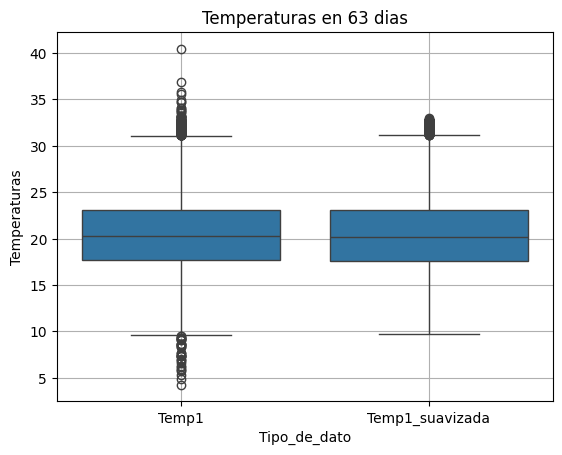

In [19]:
# Convertir a formato largo
datos_f_largo = datos_f.melt(
    value_vars=['Temp1', 'Temp1_suavizada'],
    var_name='Tipo_de_dato',
    value_name='Temperaturas'
)
sns.boxplot(x ='Tipo_de_dato', y = 'Temperaturas', data = datos_f_largo)
plt.ylabel('Temperaturas')
plt.title(f'Temperaturas en {time_up.days} dias')
plt.grid(True)
plt.savefig('Boxplot_temperaturas.png', format='png')
plt.show()

* Debido a que el sensor de temperatura no esta bien aislado de la brisa y la luz, hay mucho ruido.
* Mi solucion es entonces, suavizar los datos con el vecino cercano.

In [20]:
#Formatear eje X como HH:MM
def minutos_a_hora(x, pos):
    h = int(x) // 60
    m = int(x) % 60
    return f'{h:02d}:{m:02d}'


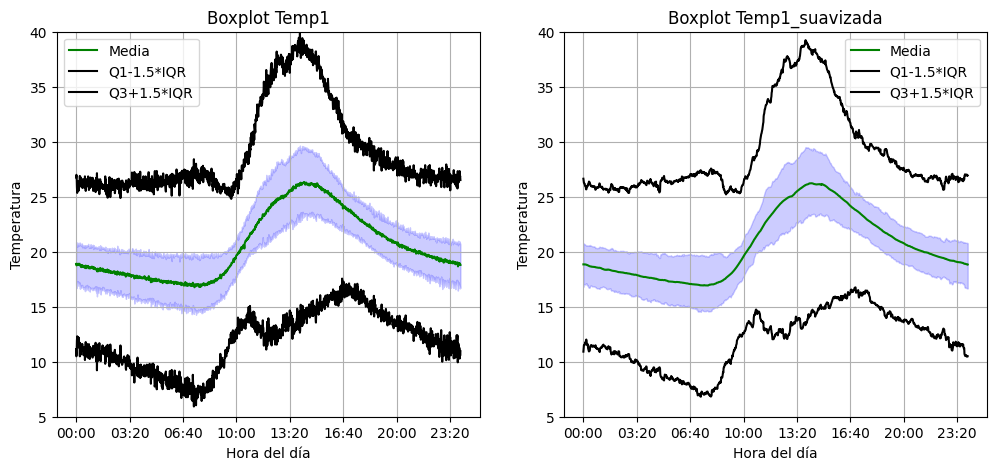

In [21]:
#Graficos de un dia particular, mostrando la diferencia entre las temperaturas
datos_q = datos_f # Copio los datos
datos_q.index = pd.to_datetime(datos_f.index)
datos_q['fecha'] = datos_q.index.date
datos_q['hora'] = datos_q.index.time

colores_boxplot = ['black', 'blue', 'green']

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
comparativa = ['Temp1','Temp1_suavizada']
grafico = [0,1]
for z in grafico:
    # Pivotear para tener horas como eje X y cada día como una columna
    df_pivot_Temp1 = datos_q.pivot(index='hora', columns='fecha', values=comparativa[z])
    dias = []
    Inicio_Eventos = [date(2025,3,15)]
    Duracion_Eventos = [time_up.days]
    dia = [[Inicio_Eventos[a] + timedelta(days=i) for i in range(Duracion_Eventos[a])] for a in range(len(Inicio_Eventos))] 
    #print(dia)
    Eventos_df = [df_pivot_Temp1[dia[i]] for i in range(len(Inicio_Eventos)) ]
    Eje_Hora = Eventos_df[0].index.map(lambda t: t.hour * 60 + t.minute + t.second / 60)
    Medias = [Eventos_df[i].mean(axis=1) for i in range(len(Inicio_Eventos)) ] 
    #Desvios = [Eventos_df[i].std(axis=1) for i in range(len(Inicio_Eventos)) ]
    ##Caja
    Q1 = [Eventos_df[i].quantile(0.25, axis=1) for i in range(len(Inicio_Eventos)) ] 
    Q3 = [Eventos_df[i].quantile(0.75, axis=1) for i in range(len(Inicio_Eventos)) ] 
    IQR = [Q3[i] - Q1[i] for i in range(len(Inicio_Eventos))]
    
    etiquetas = ['1','2','3','4']
    colores= ['#1f77b4','#d62728','#2ca02c','#ff7f0e']
    # Crear el gráfico
    # plt.figure(figsize=(10, 6))
    for i in range(len(Inicio_Eventos)):
        axes[z].plot(Eje_Hora, Medias[i], color=colores_boxplot[2], label='Media')
        #axes[z].fill_between(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), Medias[i] + (1.96 * Desvios[i]), 
                         # color=colores[i], alpha=0.2, label='±1 Desv. Estándar')
        axes[z].fill_between(Eje_Hora, Q1[i], Q3[i], 
                         color=colores_boxplot[1], alpha=0.2)
        
        axes[z].plot(Eje_Hora, Q1[i] - 1.5 * IQR[i], color=colores_boxplot[0], label='Q1-1.5*IQR')
        axes[z].plot(Eje_Hora, Q3[i] + 1.5 * IQR[i], color=colores_boxplot[0], label='Q3+1.5*IQR')
        axes[z].legend()
    
    axes[z].xaxis.set_major_formatter(ticker.FuncFormatter(minutos_a_hora))
    axes[z].set_ylim(5, 40)  # Por ejemplo, de 0 a 15
    axes[z].set_xlabel('Hora del día')
    axes[z].legend()
    axes[z].set_ylabel('Temperatura')
    axes[z].set_title(f'Boxplot {comparativa[z]}')
    axes[z].grid(True)

plt.savefig('Grafico_Temp.png', format='png')
plt.show()

### Tratamiento de la luz
* Debido a que los valores de luz eran muy bajos, procedi a remover malesas
  categorizandolas en eventos:
  * Lunes 31 de marzo, 17:00, saque unas cuantas ramas y hojas.
  * Lunes 7 de abril,  11:35-13:00, limpie bastante la pared sacando falsos cafetos
    que crecieron libremente.
  * Miercoles 23 de abril, 12:00, dia en que corte el arbol.

In [22]:
etiquetas = ['Inicio','Remocion Leve','Remocion de Arbustos','Remocion del Arbol']
colores= ['#1f77b4','#d62728','#2ca02c','#ff7f0e']


datos_q = datos_f # Copio los datos
#datos_q['Luz_suavizada'] = np.log(datos_f['Luz_suavizada']) # Copio los datos
datos_q.index = pd.to_datetime(datos_f.index)
# Crear columna con solo la fecha
datos_q['fecha'] = datos_q.index.date
# Crear columna con solo la hora (sin fecha)
datos_q['hora'] = datos_q.index.time
# Pivotear para tener horas como eje X y cada día como una curva
df_pivot = datos_q.pivot(index='hora', columns='fecha', values='Luz_suavizada')

In [30]:
dias = []
Inicio_Eventos = [date(2025,3,15),date(2025,4,1),date(2025,4,7), date(2025,4,24)]
Duracion_Eventos = [17, 6, 17, 23]
dia = [[Inicio_Eventos[a] + timedelta(days=i) for i in range(Duracion_Eventos[a])] for a in range(len(Inicio_Eventos))] 
#print(dia)
Eventos_df = [df_pivot[dia[i]] for i in range(len(Inicio_Eventos)) ]
Eje_Hora = Eventos_df[0].index.map(lambda t: t.hour * 60 + t.minute + t.second / 60)
Medias = [Eventos_df[i].mean(axis=1) for i in range(len(Inicio_Eventos)) ] 
Desvios = [Eventos_df[i].std(axis=1) for i in range(len(Inicio_Eventos)) ] 
#print(dia[3])

In [31]:
# # Crear el gráfico
# plt.figure(figsize=(10, 6))
# for i in range(len(Inicio_Eventos)):
#     plt.plot(Eje_Hora, Medias[i], label=etiquetas[i], color=colores[i])
#     plt.fill_between(Eje_Hora, Medias[i] - Desvios[i], Medias[i] + Desvios[i], 
#                      color=colores[i], alpha=0.2, label='±1 s')
#     plt.fill_between(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), Medias[i] + (1.96 *Desvios[i]), 
#                      color=colores[i], alpha=0.2, label='±1.96 s')
#     plt.plot(Eje_Hora, Medias[i] + (1.96 *Desvios[i]), color=colores[i], linestyle=':')

# plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(minutos_a_hora))
# plt.xlabel('Hora del día')
# plt.ylabel('Lux')
# plt.title('Promedio diario con IC 95%')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# ### Marcas 10000 lux

# #plt.fill_between(x, 10 ,50, color='gray', alpha=0.1)

# plt.axhline(y=1000, color='gray', linestyle='--')
# plt.text(400, 1100, 'Día nublado', color='gray', fontsize=12)
# plt.axhline(y=10000, color='red', linestyle='--')
# plt.text(400, 10100, 'Luz diurna completa', color='Red', fontsize=12)
# plt.axhline(y=25000, color='red', linestyle='--')
# plt.text(400, 25100, 'Sol directo', color='Red', fontsize=12)
# plt.ylim(0, 28000)  # Por ejemplo, de 0 a 15
# plt.xlim(left=Eje_Hora[380])
# plt.xlim(right=Eje_Hora[1180])
# plt.savefig('Grafico_Luz_Pleno_Sol.png', format='png')
# plt.show()

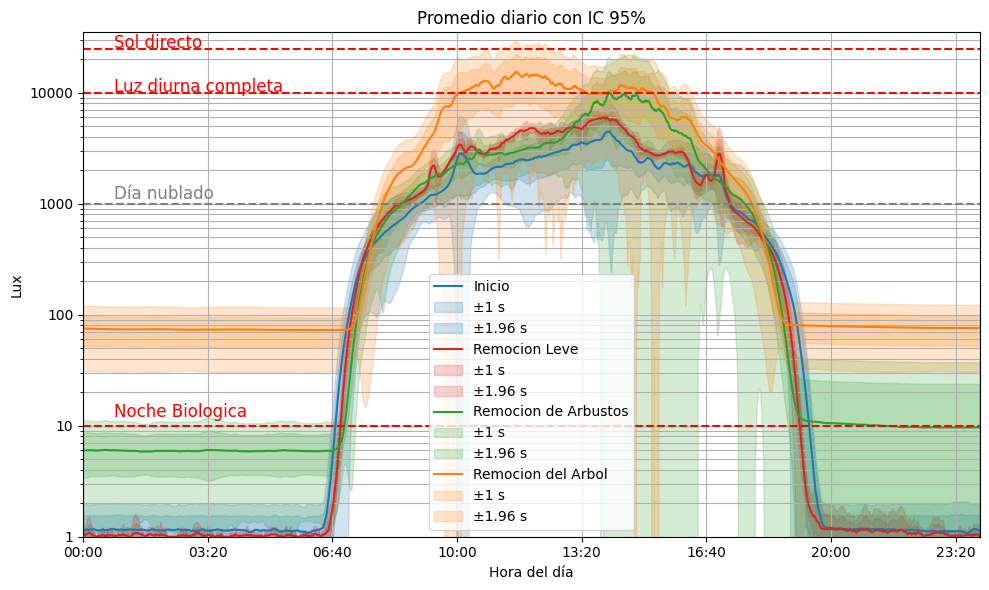

In [32]:
# Crear el gráfico
plt.figure(figsize=(10, 6))
for i in range(len(Inicio_Eventos)):
    plt.plot(Eje_Hora, Medias[i], label=etiquetas[i], color=colores[i])
    #plt.plot(Eje_Hora, Medias[i] + (1.96 *Desvios[i]), color=colores[i], linestyle='--')
    # plt.plot(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), color=colores[i], linestyle=':')
    plt.fill_between(Eje_Hora, Medias[i] - Desvios[i], Medias[i] + Desvios[i], 
                     color=colores[i], alpha=0.2, label='±1 s')
    plt.fill_between(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), Medias[i] + (1.96 *Desvios[i]), 
                     color=colores[i], alpha=0.2, label='±1.96 s')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(minutos_a_hora))
plt.xlabel('Hora del día')
plt.ylabel('Lux')
plt.title('Promedio diario con IC 95%')
plt.legend(loc = 'lower center')
plt.grid(True)
plt.tight_layout()

### Marcas

#plt.fill_between(x, 10 ,50, color='gray', alpha=0.1)
#Para mostrar en escala log sin tener que modificar todo
plt.yscale('log')

plt.axhline(y=1000, color='gray', linestyle='--')
plt.text(50, 1100, 'Día nublado', color='gray', fontsize=12)
plt.axhline(y=10000, color='red', linestyle='--')
plt.text(50, 10100, 'Luz diurna completa', color='Red', fontsize=12)
plt.axhline(y=25000, color='red', linestyle='--')
plt.text(50, 25100, 'Sol directo', color='Red', fontsize=12)
plt.axhline(y=10, color='red', linestyle='--')
plt.text(50, 12, 'Noche Biologica', color='Red', fontsize=12)
plt.ylim(1, 35000 ) # Por ejemplo, de 0 a 15
plt.xlim(left=0)
plt.xlim(right=Eje_Hora.max())


plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())  # ← ¡Esto es lo clave!
#plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())    # Opcional: ocultar los menores

plt.grid(True, which='both', axis='y') 
plt.savefig('Grafico_Lux_a_lo_largo_del_dia.png', format='png')
plt.show()

* Se puede apreciar como despues de el ultimo trabajo de remocion de malesas
  consegui que las plantas de avena consiguieran luz diurna completa.


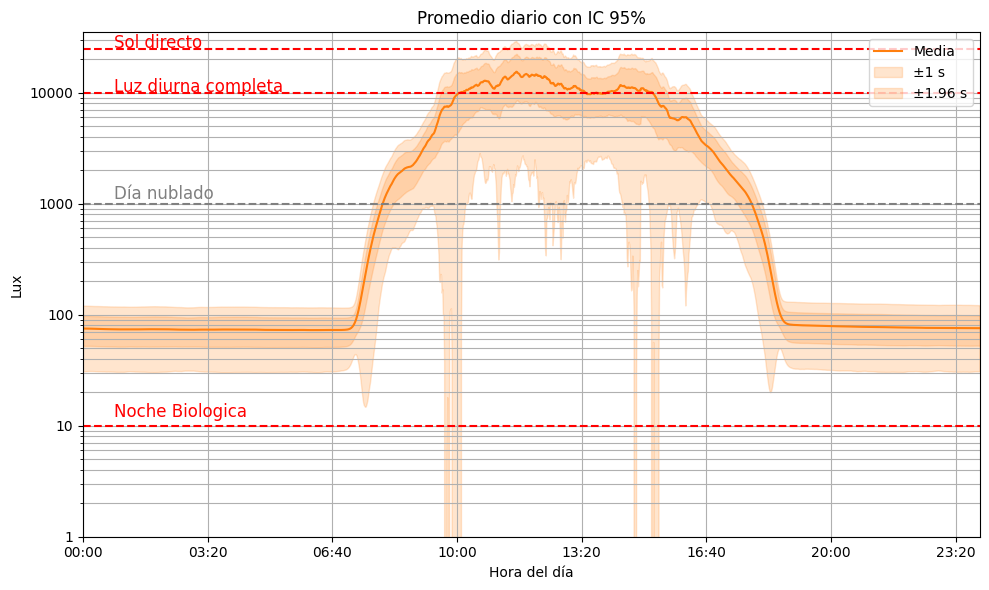

In [33]:
# Crear el gráfico
plt.figure(figsize=(10, 6))
i = 3
plt.plot(Eje_Hora, Medias[i], label='Media', color=colores[i])
#plt.plot(Eje_Hora, Medias[i] + (1.96 *Desvios[i]), color=colores[i], linestyle='--')
#plt.plot(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), color=colores[i], linestyle=':')
plt.fill_between(Eje_Hora, Medias[i] - Desvios[i], Medias[i] + Desvios[i], 
                 color=colores[i], alpha=0.2, label='±1 s')
plt.fill_between(Eje_Hora, Medias[i] - (1.96 *Desvios[i]), Medias[i] + (1.96 *Desvios[i]), 
                 color=colores[i], alpha=0.2, label='±1.96 s')

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(minutos_a_hora))
plt.xlabel('Hora del día')
plt.ylabel('Lux')
plt.title('Promedio diario con IC 95%')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.tight_layout()

### Marcas

#Para mostrar en escala log sin tener que modificar todo
plt.yscale('log')

plt.axhline(y=1000, color='gray', linestyle='--')
plt.text(50, 1100, 'Día nublado', color='gray', fontsize=12)
plt.axhline(y=10000, color='red', linestyle='--')
plt.text(50, 10100, 'Luz diurna completa', color='Red', fontsize=12)
plt.axhline(y=25000, color='red', linestyle='--')
plt.text(50, 25100, 'Sol directo', color='Red', fontsize=12)
plt.axhline(y=10, color='red', linestyle='--')
plt.text(50, 12, 'Noche Biologica', color='Red', fontsize=12)
plt.ylim(1, 35000 ) # Por ejemplo, de 0 a 15
plt.xlim(left=0)
plt.xlim(right=Eje_Hora.max())


plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())  # ← ¡Esto es lo clave!
#plt.gca().yaxis.set_minor_formatter(ticker.NullFormatter())    # Opcional: ocultar los menores

plt.grid(True, which='both', axis='y') 
plt.savefig('Grafico_Luz_Actualidad.png', format='png')
plt.show()

* Se puede apreciar como ahora se enfrenta otro problema, hay luz de noche proveniente de la estacion
  de tren aledaña que imposibilita al invernaculo tener noche biologica.
    * Esto puede influir negativamente sobre la avena que tenemos en el practico. (Singhal et al., 2022)

### Elementos a mejorar: 

* Datalogger (en si, armar otro) :
    * Medir la temperatura en un bulbo mojado para tener la humedad relativa
    * debido a que la temperatura varia bastante, tendria que agregar codigo que corrija los lux con la temp
* Invernaculo:
    * Limpiar el techo (con una hidrolavadora porque el material es suceptible a rayones).
    * Añadir una cortina automatica que garantize la oscuridad

### Citas

### Trabajo sobre la avena:

TY  - JOUR
AU  - Singhal, Rajesh
AU  - ., Indu
AU  - Ahmed, Shahid
AU  - Rana, Maneet
AU  - Kumar, Neeraj
AU  - Chand, Subhash
AU  - Priyadarshini, Parichita
PY  - 2022/09/21
SP  - 
N2  - Aim: Methodology: Results: Interpretation: The present investigation was designed to study the impact of artificial light at night on the phonological phases and yield contributing traits of fodder oat variety Kent for holistic breeding along the roadsides or highways. The experiment was conducted at Central Research Farm of ICAR-IGFRI, Jhansi, India, in a plot under natural conditions. The treatment Lc (controlled) was under natural conditions receiving normal daylight and dark periods. However, treatment L1 (300-350 lux), L2 (200-300 lux), L3 (100-200 lux), and L4 (10-50 lux) were different light affected areas having distances 0, 5, 10, and 15 m from the light source. Duncan's test, OPSTAT, and SPSS version 16.0 software were used for statistical analysis. The vegetative growth parameters such as plant height, total leaf area, flag leaf area, days to 50% flowering, panicle length, total dry biomass, and test weight were increased linearly as the distance increased from the artificial light source (minimum value for L1 treatment and maximum for Lc). However, plant population per meter square was maximum for L1 treatment and minimum for local control (Lc; no night light effect). Moreover, it is the first report of artificial light at night on the fodder oat from India and concluded that night light significantly affects the plant phenology and yield potential, and opens a new research paradigm on plant-artificial light at night interactions. Plants close to the light source received maximum intensity of night light (L1) than distantly located treatments (L2, L3, and L4). Artificial light at night-time had adverse effects on the yield-contributing traits and showed a significant negative relationship. How to cite : Singhal, R.K., Indu, S. Ahmed and S. Chand: Impacts of artificial light at night on the vegetative growth and yield attributes of fodder oat (Avena sativa).
T1  - Impacts of artificial light at night on the vegetative growth and yield attributes of fodder oat (Avena sativa)
VL  - 
DO  - 10.22438/jeb/43/6/MRN-4054
JO  - Journal of Environmental Biology
ER  - 


### Imagen del espectro de la clorofila


TY  - BOOK
AU  - Geraldo, Jonathan
PY  - 2021/11/11
SP  - 
N2  - En la fotosíntesis, la energía solar se convierte en energía química, en la fotosíntesis no se usan de igual manera todas las distintas longitudes de onda en la luz del sol ya que los organismos fotosintéticos contienen moléculas llamadas pigmentos que absorben solo las longitudes de onda específicas de la luz visible, mientras que reflejan otras.
T1  - Extracción y determinación de pigmentos fotosintéticos - Laboratorio de Bioquímica
VL  - 
DO  - 10.13140/RG.2.2.15408.28161
ER  - 

### Imagen del espectro solar 

Por Robert A. Rohde - Trabajo propio, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=2623187